In [1]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

In [3]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")
import numpy as np 
import pandas as pd 
from numbersAddTo1 import random_gen_weights
from unitCircle import unitCircle as unitCircleDf
import matplotlib.pyplot as plt
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns
np.random.seed(1986)


The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz


In [4]:
np.random.seed(1986)
n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)       
    data.append(row)
data.append([1/30]*30)

#downloading only last year as I believe is more representative of the picture going forward
df_weights = pd.DataFrame(data)
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


#%%
## 41 rows of daily pct change in aug and sept 2024
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()

training_pct_change=training_1y_endJul2024.pct_change().dropna()

[*********************100%***********************]  30 of 30 completed


array([0.        , 0.        , 0.        , 0.12      , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.32      , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01      , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01      ,
       0.53      , 0.        , 0.        , 0.        , 0.01      ,
       0.03372769, 0.05759211, 0.58563046])

In [5]:
port_means= []
port_sd = []
for row in df_weights.values: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
    port_sd.append(i_sd * np.sqrt(41))
    
#%%
#renaming columns and adding sharpe ratio
df_weights.columns = training_pct_change.columns
df_weights['port_return'] = port_means
df_weights['port_risk'] = port_sd
df_weights['sharpe'] = df_weights['port_return']/df_weights['port_risk']

**Notice that we are using Constraint and Bounds**: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

<iframe width='800px' height='800px' src='https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize'></iframe>

- sum == 1 
    -  this parameter is only used if we use SLSQP (Sequential Least Squares Programming)
- From Scipy documentation: <br>
    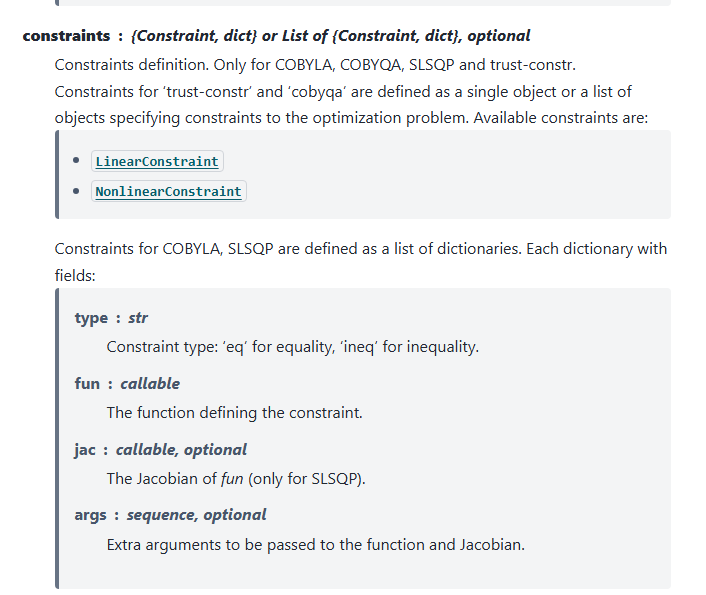 <br>
- Parameters: [0,1] <br>
    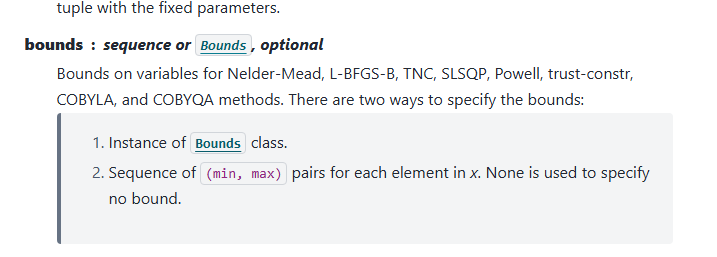

In [6]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]


## Result from Minimize

In [7]:
# Set display option for pandas
pd.set_option('display.max_columns', 500)

In [8]:
metoFila = []
for _iterRow in df_weights.values: 
    first30 = _iterRow[:30]
    totalTrue = 0
    for value in first30:
        if value == 1/30:
            totalTrue+=1
    if totalTrue == 30: 
        metoFila.append(_iterRow)

In [9]:
#initial_guess = [1. / returns.shape[1]] * returns.shape[1]
initial_guess = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:].to_list()
from scipy.optimize import minimize
result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimized Weights:", result.x)
print("Maximized Sharpe Ratio:", -result.fun)


Optimized Weights: [3.62089630e-16 1.07286016e-01 7.53232784e-02 9.05409192e-02
 2.43173702e-16 4.98160994e-16 1.97604307e-16 2.64069696e-16
 1.13554869e-16 2.15663770e-16 9.90873506e-17 2.61839727e-02
 7.36673920e-17 1.70048711e-17 9.70109926e-02 2.82405622e-16
 2.07789042e-16 1.22983157e-01 2.25489442e-16 3.00951674e-16
 3.60905917e-02 1.33856131e-16 5.43363544e-02 2.75206014e-16
 1.25023604e-17 3.28325662e-02 4.01207386e-02 1.13907432e-16
 1.12648464e-01 2.04642950e-01]
Maximized Sharpe Ratio: 1.2881776176418986


**iterating over portfolio weights to minimize**<br>

Following similar process as before


In [10]:
best100s=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0:100,:]

In [11]:
# iterating over 100 best portfolios 
best_result = 0 
best_weights = 0

for i,x in enumerate(best100s.values):
    
    #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
    initial_guess = x    
    result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if -result.fun > best_result: 
        best_result = -result.fun 
        best_weights = result.x

        print("Best Sharpe Ratio So Far:", -result.fun)

Best Sharpe Ratio So Far: 1.2881776176418986
Best Sharpe Ratio So Far: 1.28817767618092
Best Sharpe Ratio So Far: 1.288177688097352


In [18]:
# port return best weight
portfolio_return(best_weights,training_pct_change)

0.05291380046509374

In [19]:
# port return before iteration
portfolio_return(result.x,training_pct_change)

0.05291706082852254

In [12]:
# port return Dow Jones
port_returnDJI=portfolio_return(np.array([1/30 for x in range(30)]),training_pct_change)
port_returnDJI

0.02525423039591309

In [13]:
# best portfolio is 6% more volatile than the Dow Jones. But provides twice the return
portfolio_risk(best_weights,training_pct_change)/portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)

1.060412059248882

In [14]:
port_risk_DJI= portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)
port_risk_DJI

0.03873633675064717

Is there a portfolio that provides similar return but lower risk? Nope. El DJI es el portafolio que ofrece la mayor diversidad y por lo tanto el menor riesgo

In [16]:
from siuba import *
from plotnine import *

In [22]:
portfolio_return([1/30 for x in range(30)],training_pct_change)

0.025254228640388447

In [26]:
portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)

0.03873633715637284

**iterating over 100 random portfolios** <br>

In [17]:
np.random.seed(123)
allPortfolios = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True)
random100Portfolios=np.random.choice(allPortfolios.shape[0],size=100,replace=False)

In [18]:
# iterating over 100 random portfolios 
best_result = 0 
best_weights = 0

for i,x in enumerate(random100Portfolios):
    
    #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
    initial_guess = allPortfolios.iloc[x,:]    
    result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if -result.fun > best_result: 
        best_result = -result.fun 
        best_weights = result.x

        print("Best Sharpe Ratio So Far:", -result.fun)

Best Sharpe Ratio So Far: 1.288177536168488
Best Sharpe Ratio So Far: 1.288177672922095
Best Sharpe Ratio So Far: 1.288177680050761


In [19]:
from copy import deepcopy
best1_weights= deepcopy( result.x)

In [20]:
init_guess=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:]

In [21]:
init_guess=np.array( init_guess)

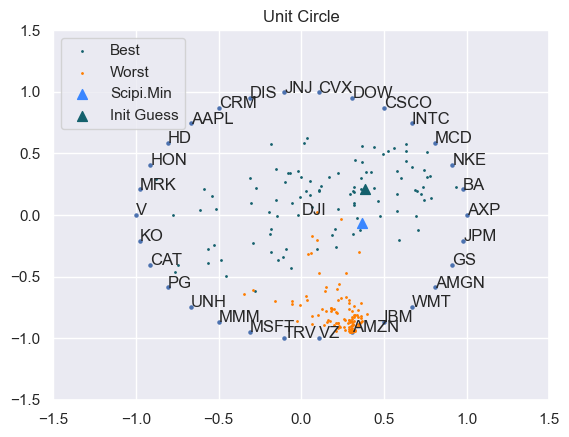

In [22]:

# PLOTTING UNICIRCLE

unitCircleDf['securities'] =\
df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:1000,:].\
        loc[:,"AAPL":"WMT"].\
            rank(axis=1, method='max',ascending=False).\
            apply(lambda x: np.count_nonzero(x<=5),axis=0).sort_values().index


#%%
nbr_portfolios = 100

best1000portfolios = df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

worst1000portfolios = df_weights.\
    sort_values('sharpe',ascending=True).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

bestPort_coord = pd.DataFrame(
    {
        'best_length': [np.array(x).dot(unitCircleDf.lengths) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values],
        'best_height': [np.array(x).dot(unitCircleDf.heights) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)

worstPort_coord = pd.DataFrame(
    {
        'worst_length': [np.array(x).dot(unitCircleDf.lengths) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values],
        'worst_height': [np.array(x).dot(unitCircleDf.heights) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)
#[value for value in best1_weights]
minimize_best1_coord =  pd.DataFrame(
    {
        'best_length': [best1_weights.dot(unitCircleDf.lengths)],
        'best_height': [best1_weights.dot(unitCircleDf.heights)]
    }
)

init_guess_coord =  pd.DataFrame(
    {
        'best_length': [init_guess.dot(unitCircleDf.lengths)],
        'best_height': [init_guess.dot(unitCircleDf.heights)]
    }
)

# plotting top n portfolios (blue), and bottom (1000) portfolios


plt.scatter(x=unitCircleDf.lengths, y=unitCircleDf.heights, s=5, color='b')
# Add labels
for i, txt in enumerate(unitCircleDf['securities']):
    plt.annotate(txt, (unitCircleDf['lengths'][i], unitCircleDf['heights'][i]))

plt.scatter(x=bestPort_coord.best_length, y=bestPort_coord.best_height, s=1, color='#15616d', label = 'Best')
plt.scatter(x=worstPort_coord.worst_length, y=worstPort_coord.worst_height, s=1, color='#ff7d00', label = 'Worst')
plt.scatter(x=minimize_best1_coord.best_length, y=minimize_best1_coord.best_height, s=50, color='#3a86ff', label = 'Scipi.Min',marker='^')
plt.scatter(x=init_guess_coord.best_length, y=init_guess_coord.best_height, s=50, color='#15616d', label = 'Init Guess',marker='^')
plt.annotate('DJI', (0, 0))
# Adding legend with bigger dots
plt.legend(markerscale=1)    



plt.xlim(-1.5, 1.5)
plt.ylim(-1.5,1.5)
plt.title('Unit Circle')
plt.show()


Note that sharpe ratio from the new optimized portfolio is 1.28 compared vs the best from random port weights of 1.07

In [86]:
df_weights.sort_values('sharpe',ascending=False).head(1)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WMT,port_return,port_risk,sharpe
14652,0.0,0.17,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.24,0.0,0.058013,0.053803,1.078258


In [23]:
for row in [best1_weights]: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    mean2months=i_mean*41
    sd2_months=i_sd * np.sqrt(41)
    print(mean2months/sd2_months)

1.2881774429622443


# Graphing Portfolio Performance

We will graph the weighted returns of the best portfolio and the dow jones

In [24]:
returns_port_training=pd.DataFrame({
    'bestPort': training_pct_change.dot(result.x),
    'DJI':training_pct_change.dot(np.array([1/30 for x in range(30)]))
})


In [25]:

def fn_dollarChangePortfolio(fn_portReturn: np.array,
                             init_dollar: int = 1_000_000 )->list[float]:    
    """ 
        This function will return the variability of money in time given portfolio returns as input and a dollar amt
    """    
    from copy import deepcopy 
    dollar_current = deepcopy(init_dollar)
    dollar_changes = []

    for x in fn_portReturn: 
        dollar_current*=(1+x)
        dollar_changes.append(dollar_current)

    return dollar_changes

In [26]:
fn_dollarChangePortfolio(returns_port_training.bestPort)

[991944.3093844386,
 991542.6110332963,
 999244.9158052452,
 1011522.6668638657,
 1010115.1596183744,
 1003570.1571237816,
 1006295.2020871241,
 1010641.877234247,
 1010217.7770938122,
 1000676.5662619657,
 996614.9250964322,
 988251.9408439543,
 990717.3708013648,
 991467.1488106683,
 984762.4451121431,
 990458.7614976444,
 984582.8885555211,
 988450.2890767443,
 994095.2317534469,
 1005779.7469961978,
 1005671.57558362,
 1006090.7301012675,
 1007107.7764003852,
 1007107.7764003852,
 1001480.2015531018,
 997309.7183477673,
 1000538.2847649388,
 1003389.6456752908,
 1011837.2620670554,
 1011094.090002749,
 1010829.0404639035,
 1021377.7057230088,
 1014671.7769777923,
 1010605.906386558,
 1009110.4470340657,
 1011720.8929886117,
 999330.1546341975,
 996061.117000069,
 997546.0041390994,
 987424.9095884417,
 984045.8069331511,
 987706.3265390757,
 979319.4797194035,
 977126.9446313524,
 964467.0688265706,
 971596.4932975695,
 971744.7562159102,
 975107.7398716361,
 978694.4516007428,
 98

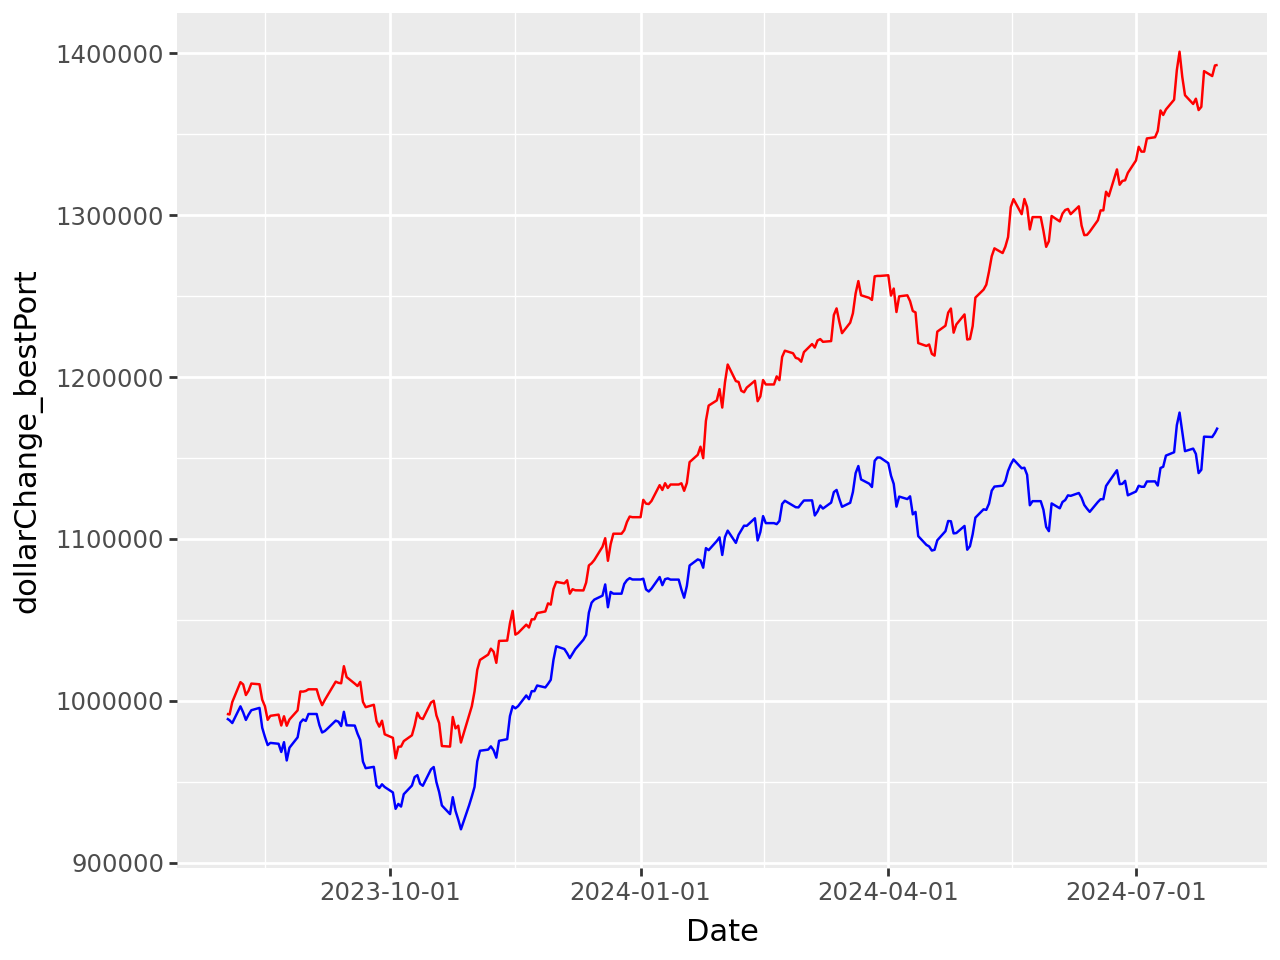

In [32]:
returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> _.reset_index()>> ggplot() + geom_line(aes(x='Date',y='dollarChange_bestPort'), color='red')+\
geom_line(aes(x='Date',y='dollarChange_DJI'), color='blue')

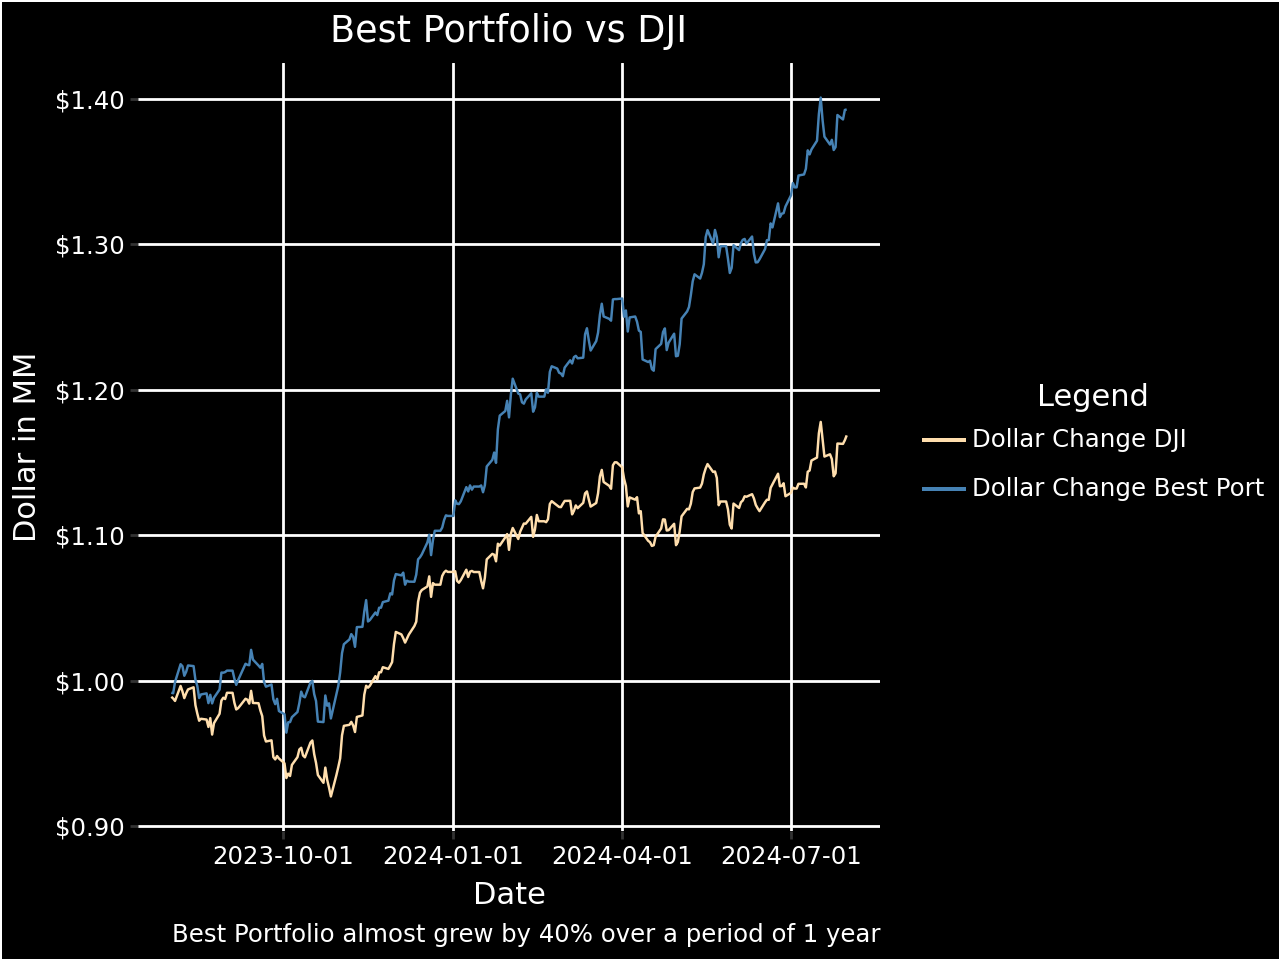

In [ ]:
graph_bestPortfolio_vs_DJI=returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> _.reset_index() >> select(_[0,3,4]) >> _.melt(id_vars = 'Date') >> \
mutate(value = _.value/1_000_000)>>\
ggplot() + geom_line(aes(x='Date', y='value', color='variable'))+\
scale_color_manual(
        values={
            'dollarChange_DJI': 'navajowhite',
            'dollarChange_bestPort': 'steelblue'
        },
        labels={
            'dollarChange_DJI': 'Dollar Change DJI',
            'dollarChange_bestPort': 'Dollar Change Best Port'
        }
    ) + scale_y_continuous(labels=lambda l: [f'${v:,.2f}' for v in l])+ \
    labs(y='Portfolio Total (MM)', title = 'Best Portfolio vs DJI', color='Legend', caption='Best Portfolio almost grew by 40% over a period of 1 year') + theme(plot_background=element_rect(fill='black'), # outside plot
                                                                    text=element_text(color='white'), # all text                                                                    
                                                                    panel_background=element_rect(fill='black'), # inside plot 
                                                                    panel_grid_minor=element_blank(), # take out minor grid 
                                                                    legend_background=element_rect(fill='black'),                                                                     
                                                                    legend_key=element_rect(fill='black'),
                                                                    legend_title=element_text(ha='center')
                                                                    )
graph_bestPortfolio_vs_DJI

In [79]:
graph_bestPortfolio_vs_DJI.save(filename = 'Best Portfolio vs DJI', height=5, width=10, units = 'in', dpi=1000)

Text(0.5, 1.0, '1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

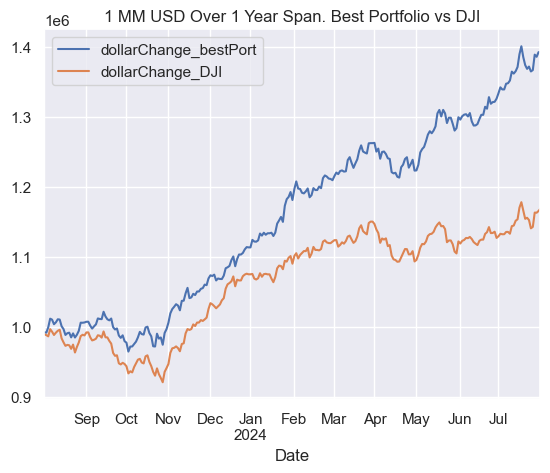

In [27]:
returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> select(2,3)>> _.plot()
plt.title('1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

In [94]:
## 41 rows of daily pct change in aug and sept 2024
testing_beginAug=df_ticker_price1["2024-07-31":"2024-09-30"].copy()

testing_Pctchange=testing_beginAug.pct_change().dropna()

In [97]:


returns_port_testing=pd.DataFrame({
    'bestPort': testing_Pctchange.dot(result.x),
    'DJI':testing_Pctchange.dot(np.array([1/30 for x in range(30)]))
})

Text(0.5, 1.0, '1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

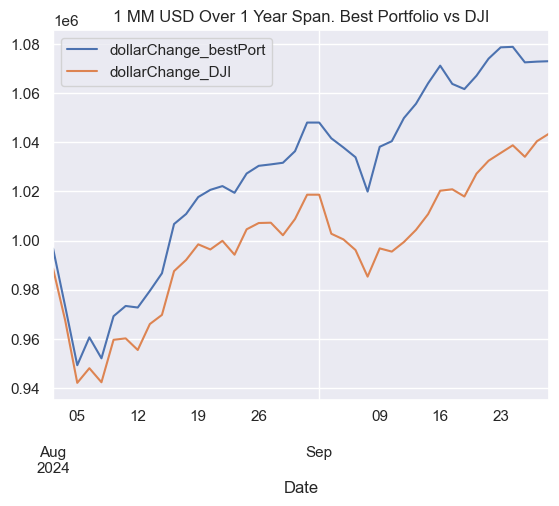

In [99]:
returns_port_testing >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> select(2,3)>> _.plot()
plt.title('1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

<Axes: xlabel='Date'>

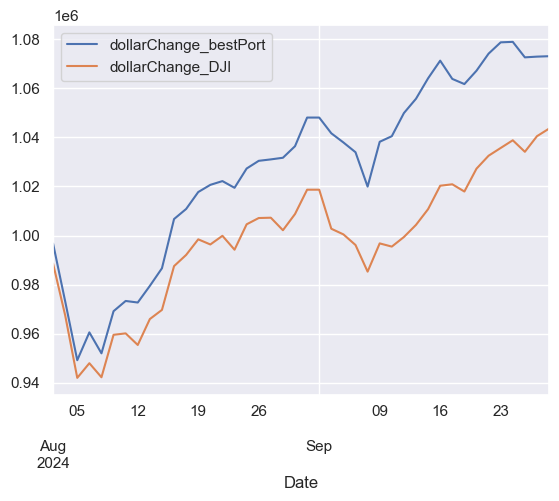

In [105]:


returns_port_testing >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> select(2,3)>> _.plot()


In [115]:
#%% 
returns_port_testing >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> \
summarize(
    bestPortReturn = _.dollarChange_bestPort[-1]/1_000_000-1,
    DJI_Return = _.dollarChange_DJI[-1]/1_000_000-1,
    bestPort_Risk = _.bestPort.std()*np.sqrt(41),
    DJI_Risk = _.DJI.std()*np.sqrt(41)
)

,bestPortReturn,DJI_Return,bestPort_Risk,DJI_Risk
0,0.073036,0.043547,0.058278,0.05859


## Investing 1 MM at the Beginning with no Portfolio Mgmt (not keeping same weight throughout)

In [128]:
training_pct_change 
dollar_init = 1_000_000
distro_dollar=result.x * dollar_init #


array([1.22309061e-10, 1.07286398e+05, 7.53232916e+04, 9.05409223e+04,
       1.40624124e-09, 8.72460385e-11, 3.26889853e-10, 2.14730123e-10,
       3.10678507e-10, 1.49528392e-10, 7.67735688e-10, 2.61841033e+04,
       1.29368179e-10, 5.31157252e-10, 9.70107720e+04, 3.58857374e-10,
       8.38583990e-10, 1.22982722e+05, 1.95819265e-11, 3.75172458e-10,
       3.60905330e+04, 2.12101344e-10, 5.43363981e+04, 1.11013191e-09,
       3.15325235e-11, 3.28326831e+04, 4.01209716e+04, 1.18315344e-10,
       1.12648158e+05, 2.04643047e+05])

In [146]:
columns_index={x:i for i,x in enumerate(training_pct_change.columns)}

training_pct_change.apply(fn_dollarChangePortfolio,init_dollar= 10,axis=0)

resultingDf=training_pct_change.apply(lambda theColumn : fn_dollarChangePortfolio(theColumn, distro_dollar[columns_index[theColumn.name]] ))

<Axes: xlabel='Date'>

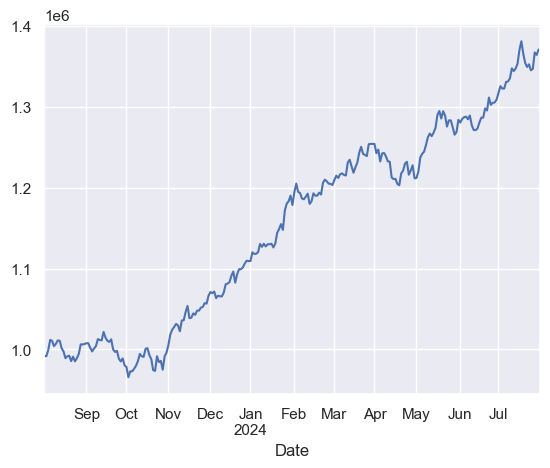

In [154]:
resultingDf.apply(sum,axis=1).plot()

### sig paso: hacer ese ultimo proceso una funcion